# Small World Graphs

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from utils import decorate, savefig

# I set the random seed so the notebook 
# produces the same results every time.
np.random.seed(17)

In [2]:
# node colors for drawing networks
colors = sns.color_palette('pastel', 5)
#sns.palplot(colors)
sns.set_palette(colors)

In [3]:
#From Chapter 3 notebook:

def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

def make_ws_graph(n, k, p):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G)
    for u, v in G.edges():
        if flip(p):
            choices = nodes - {u} - set(G[u])
            new_v = np.random.choice(list(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)
            
def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p

**Exercise 3.5:** A natural question about the Watts and Strogatz paper is whether the small world phenomenon is specific to their generative model or whether other similar models yield the same qualitative result (high clustering and low path lengths).

To answer this question, choose a variation of the Watt-Strogatz model and repeat the experiment.

We consider a rewiring strategy that preferably chooses to rewire nodes among a set of kth neighbors e.g. 2nd nearest neighbor, etc. (In the book, the rewiring chooses among all non-neighboring nodes). We implement a function that gets the kth neighbors of a specific node.

In [4]:
def kth_neighbor(G, start, k):
    #Function that gets all k neighbors of the node start for a graph G.
    neighbors = set([start])
    for i in range(k):
        neighbors = set((neighbor for n in neighbors for neighbor in G[n]))
    return neighbors

We create a new rewiring function:

In [5]:
def new_rewire(G, p, k_neighbor):
    nodes = set(G)
    original_edges = G.edges()
    for u, v in original_edges:
        if (np.random.random() < p):#True if random number is less than threshold, if p = 1, 100% chance to rewire edges
            choices = nodes - {u} - kth_neighbor(G, u, k_neighbor)
            new_v = np.random.choice(list(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)

We can test show the possible choices for neighbors here

In [6]:
test = make_ring_lattice(1000,100)

In [7]:
nodes = set(test)
u = 0
k_neighbor = 2
len(nodes - {u} - kth_neighbor(test, u, k_neighbor))

799

In [8]:
nodes = set(test)
u = 0
len(nodes - {u} - set(test[u]))

899

We see here that the kth_neighbor has more restricted options for nodes to rewire to compared to the original rewiring in the book. We can run the same experiment as in the example to see if changing the rewiring shows the same properties expected for a WS network.

In [9]:
def make_ws_graph_modified(n, k, p, k_neighbor = 2):
    #A modified WS with a different wiring strategy
    ws = make_ring_lattice(n, k)
    new_rewire(ws, p, k_neighbor)
    return ws

In [10]:
#From the original notebook:

#For calculating characteristic path length:

def path_lengths(G):
    length_iter = nx.shortest_path_length(G)
    for source, dist_map in length_iter:
        for dest, dist in dist_map.items():
            yield dist

def characteristic_path_length(G):
    return np.mean(list(path_lengths(G)))

### For measuring clustering

def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    possible = k * (k-1) / 2
    exist = 0    
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist +=1
    return exist / possible

def all_pairs(nodes):
    """Generates all pairs of nodes."""
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    cu = [node_clustering(G, node) for node in G]
    return np.nanmean(cu)

In [11]:
def run_one_graph_modified(n, k, p, k_neighbor = 2):
    ws = make_ws_graph_modified(n, k, p, k_neighbor)  
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    #print(mpl, cc)
    return mpl, cc

In [12]:
def run_experiment(ps, n=1000, k=10, iters=20):
    """Computes stats for WS graphs with a range of `p`.
    
    ps: sequence of `p` to try
    n: number of nodes
    k: degree of each node
    iters: number of times to run for each `p`
    
    returns:
    """
    res = []
    for p in ps:
        print('Running %s iterations for p = %f, n = %s' % (iters, p, n))
        t = [run_one_graph_modified(n, k, p) for _ in range(iters)]
        means = np.array(t).mean(axis=0)
        res.append(means)
    return np.array(res)

In [13]:
ps = np.logspace(-4, 0, 9) #From 10^-4 to 1
res = run_experiment(ps)

Running 20 iterations for p = 0.000100, n = 1000
Running 20 iterations for p = 0.000316, n = 1000
Running 20 iterations for p = 0.001000, n = 1000
Running 20 iterations for p = 0.003162, n = 1000
Running 20 iterations for p = 0.010000, n = 1000
Running 20 iterations for p = 0.031623, n = 1000
Running 20 iterations for p = 0.100000, n = 1000
Running 20 iterations for p = 0.316228, n = 1000
Running 20 iterations for p = 1.000000, n = 1000


In [14]:
L, C = np.transpose(res)

In [15]:
L /= L[0]
C /= C[0]

#Normalize to start at 1

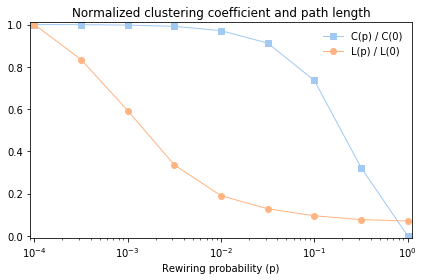

In [16]:
plt.plot(ps, C, 's-', linewidth=1, label='C(p) / C(0)')
plt.plot(ps, L, 'o-', linewidth=1, label='L(p) / L(0)')
decorate(xlabel='Rewiring probability (p)', xscale='log',
         title='Normalized clustering coefficient and path length',
         xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])

The plot above is the same plot we get as the one in the example. There's high clustering and low path lengths for a considerable number of probabilities as in the example.

Let's see what happens for a ring lattice with more neighbors (n = 500, different k)

Running 20 iterations for p = 0.000100, n = 500
Running 20 iterations for p = 0.000316, n = 500
Running 20 iterations for p = 0.001000, n = 500
Running 20 iterations for p = 0.003162, n = 500
Running 20 iterations for p = 0.010000, n = 500
Running 20 iterations for p = 0.031623, n = 500
Running 20 iterations for p = 0.100000, n = 500
Running 20 iterations for p = 0.316228, n = 500
Running 20 iterations for p = 1.000000, n = 500


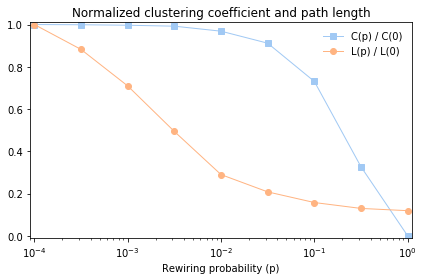

In [28]:
ps = np.logspace(-4, 0, 9) #From 10^-4 to 1

res = run_experiment(ps, n = 500, k = 10)
L, C = np.transpose(res)
L /= L[0]
C /= C[0]

#Normalize to start at 1

plt.plot(ps, C, 's-', linewidth=1, label='C(p) / C(0)')
plt.plot(ps, L, 'o-', linewidth=1, label='L(p) / L(0)')
decorate(xlabel='Rewiring probability (p)', xscale='log',
         title='Normalized clustering coefficient and path length',
         xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])

Running 20 iterations for p = 0.000100, n = 500
Running 20 iterations for p = 0.000316, n = 500
Running 20 iterations for p = 0.001000, n = 500
Running 20 iterations for p = 0.003162, n = 500
Running 20 iterations for p = 0.010000, n = 500
Running 20 iterations for p = 0.031623, n = 500
Running 20 iterations for p = 0.100000, n = 500
Running 20 iterations for p = 0.316228, n = 500
Running 20 iterations for p = 1.000000, n = 500


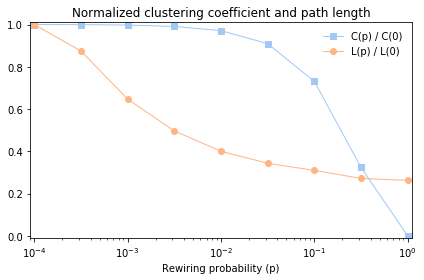

In [29]:
ps = np.logspace(-4, 0, 9) #From 10^-4 to 1

res = run_experiment(ps, n = 500, k = 30)

L, C = np.transpose(res)
L /= L[0]
C /= C[0]

#Normalize to start at 1

plt.plot(ps, C, 's-', linewidth=1, label='C(p) / C(0)')
plt.plot(ps, L, 'o-', linewidth=1, label='L(p) / L(0)')
decorate(xlabel='Rewiring probability (p)', xscale='log',
         title='Normalized clustering coefficient and path length',
         xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])

Running 20 iterations for p = 0.000100, n = 500
Running 20 iterations for p = 0.000316, n = 500
Running 20 iterations for p = 0.001000, n = 500
Running 20 iterations for p = 0.003162, n = 500
Running 20 iterations for p = 0.010000, n = 500
Running 20 iterations for p = 0.031623, n = 500
Running 20 iterations for p = 0.100000, n = 500
Running 20 iterations for p = 0.316228, n = 500
Running 20 iterations for p = 1.000000, n = 500


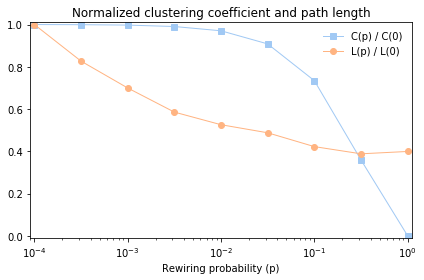

In [30]:
ps = np.logspace(-4, 0, 9) #From 10^-4 to 1

res = run_experiment(ps, n = 500, k = 50)

L, C = np.transpose(res)
L /= L[0]
C /= C[0]

#Normalize to start at 1

plt.plot(ps, C, 's-', linewidth=1, label='C(p) / C(0)')
plt.plot(ps, L, 'o-', linewidth=1, label='L(p) / L(0)')
decorate(xlabel='Rewiring probability (p)', xscale='log',
         title='Normalized clustering coefficient and path length',
         xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])

We see here that the increased number of nodes also increased the path length.